In [188]:
"""Train 3 neural networks to obtain a prediction interval for the data."""

import dataclasses as dc
import time
from pathlib import Path
from typing import Literal, Optional, TypeVar, Callable

import keras
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from scipy import optimize
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import utils
import utils.commandline
from utils.files import MySmartFile, MySmartFolder, MyDir, load_json, save_json

BLOCK = False
T = TypeVar("T")


class MaxOneScaler:
    def __init__(self):
        self.scale_ = None

    def fit(self, X):
        x_abs_max = np.max(np.abs(X), axis=0)
        if np.any(x_abs_max == 0):
            raise ValueError(
                "Cannot scale data with features having a maximum absolute value of zero."
            )
        self.scale_ = 1.0 / x_abs_max
        return self

    def transform(self, X):
        if self.scale_ is None:
            raise ValueError("Scaler is not fitted yet. Call 'fit' before 'transform'.")
        X = np.asarray(X).copy()
        return X * self.scale_

    def inverse_transform(self, X):
        if self.scale_ is None:
            raise ValueError("Scaler is not fitted yet. Call 'fit' before 'transform'.")
        X = np.asarray(X).copy()
        return X / self.scale_

    def fit_transform(self, X):
        return self.fit(X).transform(X)


@dc.dataclass
class TrainingParams:
    max_epochs: int = 600
    initial_learning_rate: float = 0.1
    batch_size: Optional[int] = 8  # if None, batch size equals dataset size
    activation: str = "tanh"
    loss_fun: str = "mse"
    optimizer: str = "adam"
    validation_fraction: float = 0.2
    stop_early: bool = True
    n_neurons_per_layer: list[int] = dc.field(default_factory=lambda: [32])

    @classmethod
    def good_std_defaults(cls):
        return TrainingParams(
            # max_epochs=2500,
            max_epochs=1700,
            stop_early=False,
            initial_learning_rate=0.01,
            n_neurons_per_layer=[64],
            validation_fraction=0.1,
            batch_size=None,
        )


@dc.dataclass
class ExperimentParams:
    # TODO: Check that each param is used
    out_dir: Path
    x_data_path: Path
    y_data_path: Path
    quantiles: list[float] = dc.field(default_factory=lambda: [0.95, 0.9, 0.85, 0.8])
    seed: int = dc.field(default_factory=lambda: time.time_ns() % 10**9)
    debug: bool = False
    visualize: bool = True
    load_checkpoint: bool = True
    positivity_method: str = "softplus"
    verbose: int = 1
    # l2_regularization: float = 0.000001  # works but little low
    # l2_regularization: float = 0.0001  # works but little strong
    l2_regularization: float = 0.00001  # works but little strong


class ScaledTrainingModel(keras.Model):
    def __init__(
        self, model: keras.Model, x_scaler: MinMaxScaler, y_scaler: StandardScaler
    ):
        super().__init__()
        self.model = model
        self.x_scaler = x_scaler
        self.y_scaler = y_scaler

    def fit(self, x, y, *args, **kwargs):
        x = self.x_scaler.transform(x)
        y = self.y_scaler.transform(y)
        return super().fit(x, y, *args, **kwargs)

    def call(self, x, *args, **kwargs):
        return self.model.call(x, *args, **kwargs)

    def predict(self, x):
        x_scaled = self.x_scaler.transform(x)
        y_scaled = self.model.predict(x_scaled)
        return self.y_scaler.inverse_transform(y_scaled)


def make_model(
    x_train,
    y_train,
    layer_sizes: list[int],
    activation,
    # normalizer,
    positivity_method=None,
    l2_reg: float = 0.0,
):
    model = keras.Sequential(
        [
            keras.Input(shape=(x_train.shape[1],)),
            # normalizer,
            # keras.layers.LayerNormalization(),
            # keras.layers.BatchNormalization(),
            *[
                keras.layers.Dense(
                    n,
                    activation=activation,
                    kernel_regularizer=keras.regularizers.l2(l2_reg)
                    if l2_reg != 0.0
                    else None,
                )
                for n in layer_sizes
            ],
            keras.layers.Dense(y_train.shape[1]),
        ]
    )

    if positivity_method:
        x = model(model.inputs)
        x = {
            "sqrt_sqr": lambda: keras.ops.sqrt(keras.ops.square(x) + 1e-12),  # type: ignore
            "abs": lambda: keras.ops.abs(x),
            "relu": lambda: keras.layers.ReLU()(x),  # bad option
            "softplus": lambda: keras.layers.Activation("softplus")(x),
            "exp": lambda: keras.layers.Activation("exponential")(x),
        }.get(
            positivity_method,
            lambda: ValueError(f"Unknown positivity method: {positivity_method}"),
        )()
        model = keras.Model(model.input, x)

        model = ScaledTrainingModel(
            model,
            x_scaler=MinMaxScaler().fit(x_train),
            y_scaler=MaxOneScaler().fit(y_train),  # type: ignore
        )
    else:
        model = ScaledTrainingModel(
            model,
            x_scaler=MinMaxScaler().fit(x_train),
            y_scaler=StandardScaler().fit(y_train),
        )

    return model


def read_commandline():
    parser = utils.commandline.parser_from_dataclasses(
        [ExperimentParams, TrainingParams, TrainingParams],
        postfixes=["", "_mean", "_std"],
        positional_args={"out_dir", "x_data_path", "y_data_path"},
    )
    clargs = vars(parser.parse_args())
    params = (
        utils.commandline.dict_to_dataclass(TrainingParams, clargs, consume=True),
        utils.commandline.dict_to_dataclass(ExperimentParams, clargs, consume=True),
    )
    assert len(clargs) == 0
    return params


def preprocess_data(arr: np.ndarray) -> np.ndarray:
    arr = np.squeeze(arr)
    if arr.ndim > 2:
        raise ValueError(f"Too many dimensions: {arr.shape}")

    if arr.ndim == 1:
        return arr[:, np.newaxis]

    assert arr.ndim == 2

    return arr


@dc.dataclass
class TrainingResult:
    model: keras.Model
    x_train: np.ndarray
    y_train: np.ndarray
    x_eval: np.ndarray
    y_eval_pred: np.ndarray
    y_train_pred: np.ndarray
    loss_train: np.ndarray
    learning_rates: np.ndarray

    @property
    def can_plot(self):
        return self.x_train.shape[1] == 1 and self.y_train.shape[1] == 1

    def plot(self, title: str):
        if not self.can_plot:
            return
        plt.figure()
        plt.title(title)
        plt.scatter(self.x_train, self.y_train, alpha=0.5)
        plt.plot(self.x_eval, self.y_eval_pred, "k-", lw=3)


def train_model(
    model,
    x_train,
    y_train,
    x_eval,
    training_params: TrainingParams,
    experiment_params: ExperimentParams,
    lr_schedule,
) -> TrainingResult:
    if isinstance(model, keras.Model):
        if experiment_params.debug:
            print("=" * 100)
            print("Warning: Running eagerly is slow!")
            print("=" * 100)

        lr_scheduler = keras.callbacks.LearningRateScheduler(
            lambda s: float(lr_schedule(s))  # type: ignore
        )

        model.compile(
            loss=training_params.loss_fun,
            optimizer=keras.optimizers.get(
                {
                    "class_name": training_params.optimizer,  # type: ignore
                    "config": {"learning_rate": training_params.initial_learning_rate},
                }
            ),
            run_eagerly=experiment_params.debug,
        )

        callbacks = [lr_scheduler]
        if training_params.stop_early:
            callbacks.append(
                keras.callbacks.EarlyStopping(
                    monitor="loss",
                    patience=20,
                    restore_best_weights=True,
                    min_delta=0.0005,  # type: ignore
                )
            )

        history = model.fit(
            x_train,
            y_train,
            shuffle=True,
            epochs=training_params.max_epochs,
            batch_size=training_params.batch_size or x_train.shape[0],
            validation_split=training_params.validation_fraction,
            callbacks=callbacks,
            verbose=experiment_params.verbose,  # type: ignore
        )

        train_loss = np.array(history.history["loss"])
        try:
            used_learning_rates = np.array(
                [lr_schedule(s) for s, _ in enumerate(train_loss)]
            )
        except NameError:
            used_learning_rates = np.array([])
    else:
        train_loss = np.array([])
        used_learning_rates = np.array([])

    y_eval_pred = model.predict(x_eval)
    y_train_pred = model.predict(x_train)

    return TrainingResult(
        model=model,
        x_train=x_train,
        y_train=y_train,
        x_eval=x_eval,
        y_eval_pred=y_eval_pred,
        y_train_pred=y_train_pred,
        loss_train=train_loss,
        learning_rates=used_learning_rates,
    )


class P3innDir(MyDir):
    def __init__(self, path):
        super().__init__(path)

        self.config = MySmartFile(path / "p3inn_params.json")
        self.x_data = MySmartFile(path / "x_data.npy")
        self.y_data = MySmartFile(path / "y_data.npy")
        self.x_eval = MySmartFile(path / "x_eval.npy")
        self.pred_mean = MySmartFile(path / "pred_mean.npy")
        self.pred_median = MySmartFile(path / "pred_median.npy")
        self.loss = MySmartFile(path / "p3inn_loss.txt")

        # self.pred_PIs_dir = MySmartFolder(path / "pred_PIs", "ts1data_{}.npy")

    @property
    def pred_PIs_dir(self) -> Path:
        p = self.path / "pred_PIs/"
        p.mkdir(exist_ok=True, parents=True)
        return p

    def get_pred_bound_file(
        self, quantile: float, bound_type: Literal["up", "down"]
    ) -> MySmartFile:
        return MySmartFile(self.pred_PIs_dir / f"PI_{bound_type}_{quantile:g}.npy")

    def iter_pred_PIs(self):
        quantile_and_PI_paths = []
        for up_path in self.pred_PIs_dir.glob("*_up_*.npy"):
            quantile = float(up_path.stem.split("_")[-1])
            down_path = up_path.parent / up_path.name.replace("_up_", "_down_")
            quantile_and_PI_paths.append((quantile, up_path, down_path))

        quantile_and_PI_paths = sorted(quantile_and_PI_paths, key=lambda t: t[0])

        for q, u, d in quantile_and_PI_paths:
            yield q, np.load(u), np.load(d)

    @property
    def processed_data_dir(self) -> Path:
        p = self.path / "processed_data/"
        p.mkdir(exist_ok=True, parents=True)
        return p

    @property
    def image_dir(self) -> Path:
        p = self.processed_data_dir / "p3inn_images/"
        p.mkdir(exist_ok=True, parents=True)
        return p


def pi3nn_compute_PI_and_mean(
    out_dir,
    quantiles: list[float],
    x_data_path=None,
    y_data_path=None,
    seed=None,
    visualize=False,
    passed_net_mean=None,
    max_iter=50000,
    load_from_dir: bool = True,
):
    seed = int(hash(out_dir)) % 2**31 if seed is None else int(seed)

    p3inn_dir = P3innDir(Path(out_dir))

    if x_data_path is None:
        x_data_path = p3inn_dir.x_data.path
    if y_data_path is None:
        y_data_path = p3inn_dir.y_data.path

    main(
        TrainingParams(
            max_epochs=max_iter,
        ),
        ExperimentParams(
            out_dir=out_dir,
            x_data_path=x_data_path,
            y_data_path=y_data_path,
            quantiles=quantiles,
            seed=seed,
            load_checkpoint=load_from_dir,
            visualize=visualize,
        ),
        passed_net_mean=passed_net_mean,
    )


def to_keras_model_proxy(fun):
    class Proxy:
        def __call__(self, x):
            return fun(x)

        def predict(self, x):
            return fun(x)

    return Proxy


# Main Function

In [56]:
out_dir = Path("../data_out/tmp123/p3inn_core2")
out_dir.resolve()

PosixPath('/Users/r/Documents/stud/ss24/finnpinn/data_out/tmp123/p3inn_core2')

In [57]:
training_params_mean = TrainingParams()
training_params_std = TrainingParams.good_std_defaults()
experiment_params = ExperimentParams(
    out_dir=out_dir,
    x_data_path=Path("../data_out/p3inn/core2/x_data.npy"),
    y_data_path=Path("../data_out/p3inn/core2/y_data.npy"),
    quantiles=[0.95, 0.9, 0.7],
    seed=387465,
    load_checkpoint=False,
    visualize=True,
)
passed_net_mean = None

TrainingParams(max_epochs=600, initial_learning_rate=0.1, batch_size=8, activation='tanh', loss_fun='mse', optimizer='adam', learning_rate_schedule='constant', validation_fraction=0.2, stop_early=True, n_neurons_per_layer=[32]) TrainingParams(max_epochs=1700, initial_learning_rate=0.01, batch_size=None, activation='tanh', loss_fun='mse', optimizer='adam', learning_rate_schedule='constant', validation_fraction=0.1, stop_early=False, n_neurons_per_layer=[64]) ExperimentParams(out_dir=PosixPath('../data_out/tmp123/p3inn_core2'), x_data_path=PosixPath('../data_out/p3inn/core2/x_data.npy'), y_data_path=PosixPath('../data_out/p3inn/core2/y_data.npy'), quantiles=[0.95, 0.9, 0.7], seed=387465, debug=False, visualize=True, load_checkpoint=False, positivity_method='softplus', verbose=1, l2_regularization=1e-05)


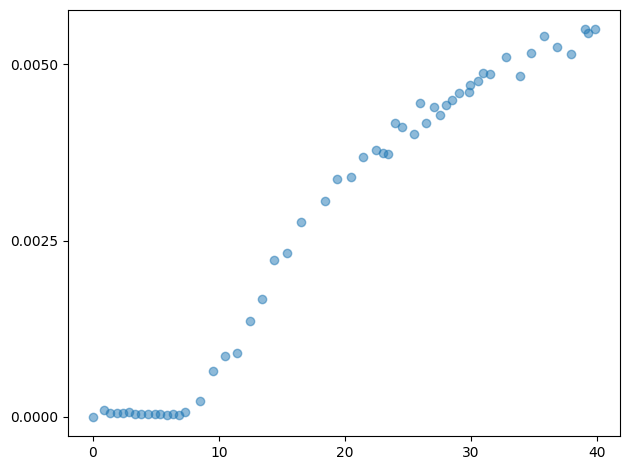

In [58]:
print(training_params_mean, training_params_std, experiment_params)

keras.utils.set_random_seed(experiment_params.seed)

p3inn_dir = P3innDir(experiment_params.out_dir)

x_data = preprocess_data(np.load(experiment_params.x_data_path))
y_data = preprocess_data(np.load(experiment_params.y_data_path))
p3inn_dir.x_data.save(x_data)
p3inn_dir.y_data.save(y_data)


if x_data.shape[1] == 1:
    x_eval = np.linspace(x_data.min(), x_data.max(), 1000).reshape(-1, 1)
else:
    x_eval = x_data.copy()  # TODO: Should be a grid
p3inn_dir.x_eval.save(x_eval)


plt.figure()
plt.scatter(x_data, y_data, alpha=0.5)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(3))
plt.tight_layout()
plt.savefig(p3inn_dir.image_dir / "input_data.png")
if not experiment_params.visualize:
    plt.close()
else:
    plt.show(block=BLOCK)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step


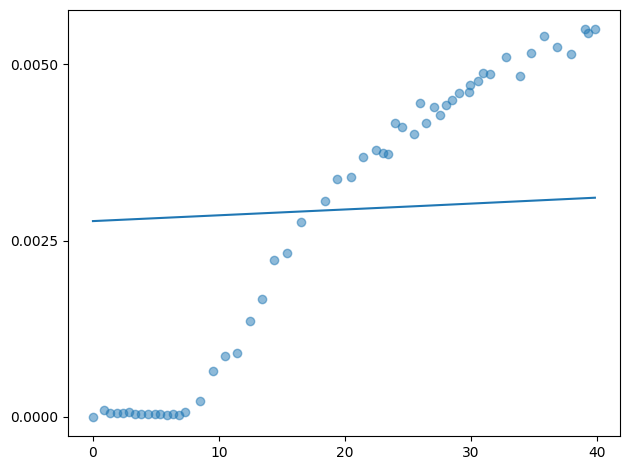

In [59]:
if passed_net_mean is None:
    if experiment_params.load_checkpoint and p3inn_dir.pred_mean.path.exists():
        # load checkpoint
        def mean_model(x):
            return np.interp(
                x.squeeze(), x_eval.squeeze(), p3inn_dir.pred_mean.load().squeeze()
            )

        mean_model = to_keras_model_proxy(mean_model)  # type: ignore
    else:
        # normalizer = keras.layers.Normalization(axis=-1)
        # normalizer.adapt(x_data)
        mean_model = make_model(
            x_data,
            y_data,
            layer_sizes=training_params_mean.n_neurons_per_layer,
            activation=training_params_mean.activation,
            # normalizer=normalizer,
        )
        # mean_model.summary()  # type: ignore
else:
    mean_model = to_keras_model_proxy(passed_net_mean)  # type: ignore


plt.figure()
plt.scatter(x_data, y_data, alpha=0.5)
plt.plot(x_eval, mean_model.predict(x_eval), "-")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(3))
plt.tight_layout()
plt.savefig(p3inn_dir.image_dir / "initial_mean_model.png")
if not experiment_params.visualize:
    plt.close()
else:
    plt.show(block=BLOCK)

Epoch 1/600
Epoch 2/600
Epoch 3/600
Epoch 4/600
Epoch 5/600
Epoch 6/600
Epoch 7/600
Epoch 8/600
Epoch 9/600
Epoch 10/600
Epoch 11/600
Epoch 12/600
Epoch 13/600
Epoch 14/600
Epoch 15/600
Epoch 16/600
Epoch 17/600
Epoch 18/600
Epoch 19/600
Epoch 20/600
Epoch 21/600
Epoch 22/600
Epoch 23/600
Epoch 24/600
Epoch 25/600
Epoch 26/600
Epoch 27/600
Epoch 28/600
Epoch 29/600
Epoch 30/600
Epoch 31/600
Epoch 32/600
Epoch 33/600
Epoch 34/600
Epoch 35/600
Epoch 36/600
Epoch 37/600
Epoch 38/600
Epoch 39/600
Epoch 40/600
Epoch 41/600
Epoch 42/600
Epoch 43/600
Epoch 44/600
Epoch 45/600
Epoch 46/600
Epoch 47/600
Epoch 48/600
Epoch 49/600
Epoch 50/600
Epoch 51/600
Epoch 52/600
Epoch 53/600
Epoch 54/600
Epoch 55/600
Epoch 56/600
Epoch 57/600
Epoch 58/600
Epoch 59/600
Epoch 60/600
Epoch 61/600
Epoch 62/600
Epoch 63/600
Epoch 64/600
Epoch 65/600
Epoch 66/600
Epoch 67/600
Epoch 68/600
Epoch 69/600
Epoch 70/600
Epoch 71/600
Epoch 72/600
Epoch 73/600
Epoch 74/600
Epoch 75/600
Epoch 76/600
Epoch 77/600
Epoch 78

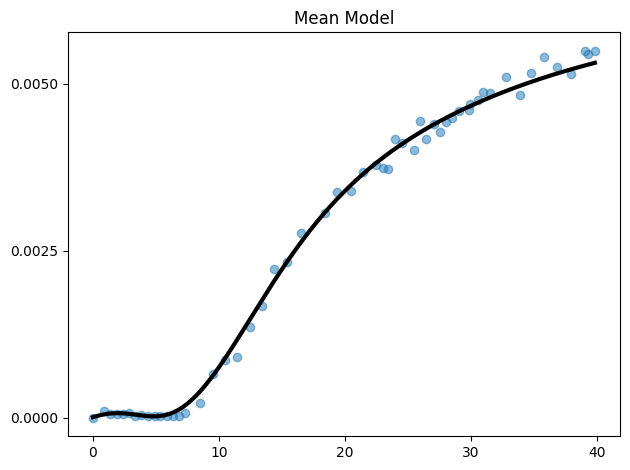

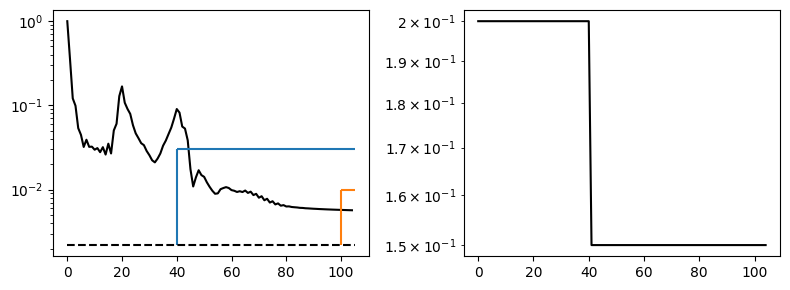

In [60]:
mean_result = train_model(
    mean_model,
    x_data,
    y_data,
    x_eval,
    training_params_mean,
    experiment_params,
    lr_schedule=keras.optimizers.schedules.PiecewiseConstantDecay(
        # [ 30,   60, 180], [0.2, 0.15, 0.1, 0.01]  # extremely good (almost done at 200)
        # [ 30,   60, 210], [0.2, 0.15, 0.1, 0.01]  # even better
        [40, 160], [0.2, 0.15, 0.01],  # not better in total but converged at 170
    ),
)
p3inn_dir.pred_mean.save(mean_result.y_eval_pred)

mean_result.plot("Mean Model")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(3))
plt.tight_layout()
plt.savefig(p3inn_dir.image_dir / "transformed_data_split.png")
if not experiment_params.visualize:
    plt.close()
else:
    plt.show(block=BLOCK)

if len(mean_result.loss_train) > 0:
    fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
    axs[0].semilogy(mean_result.loss_train, "k-")
    axs[1].semilogy(mean_result.learning_rates, "k-")

    # --------------

    EPOCHS_AND_THRESHOLDS = [
        (40, 0.03),
        (100, 0.01),
        (400, 0.0022),
    ]

    for i, (n, a) in enumerate(EPOCHS_AND_THRESHOLDS[:-1]):
        axs[0].vlines(n, 0.0022, a, color=f"C{i}")
        axs[0].hlines(a, n, len(mean_result.loss_train), color=f"C{i}")
    axs[0].plot(
        [0, len(mean_result.loss_train)], [EPOCHS_AND_THRESHOLDS[-1][1]] * 2, "k--"
    )
    # --------------

    plt.tight_layout()
    plt.savefig(p3inn_dir.image_dir / "mean_loss_and_lrs.png")
    if not experiment_params.visualize:
        plt.close()
    else:
        plt.show(block=BLOCK)

median_shift=-4.288706391100409e-06


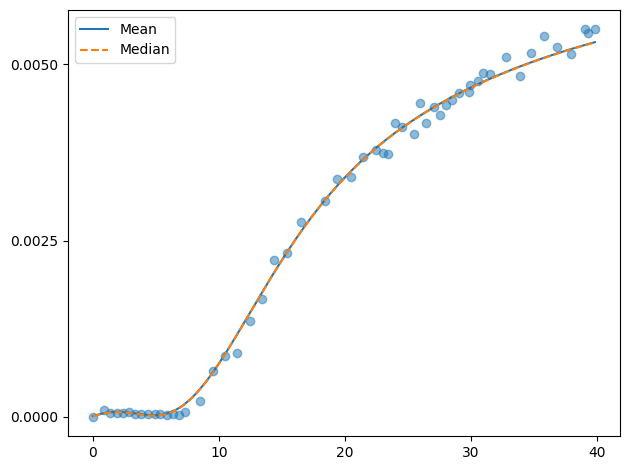

In [61]:
# Compute and split residuals
mean_residuals = y_data - mean_result.y_train_pred
median_shift = np.median(mean_residuals)
y_eval_pred_median = mean_result.y_eval_pred + median_shift
p3inn_dir.pred_median.save(y_eval_pred_median)

median_residuals = mean_residuals - median_shift
print(f"{median_shift=}")
pos_mask = median_residuals > 0
neg_mask = median_residuals < 0

assert (
    abs(np.count_nonzero(pos_mask) - np.count_nonzero(neg_mask)) <= 1
), "Residuals are not evenly split"

n_below = np.count_nonzero(
    y_data < np.interp(x_data, mean_result.x_eval.flat, y_eval_pred_median.flat)
)
n_above = np.count_nonzero(
    y_data > np.interp(x_data, mean_result.x_eval.flat, y_eval_pred_median.flat)
)

plt.figure()
plt.scatter(x_data, y_data, alpha=0.5)
plt.plot(mean_result.x_eval, mean_result.y_eval_pred, "-", label="Mean")
plt.plot(mean_result.x_eval, y_eval_pred_median, "--", label="Median")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(3))
plt.tight_layout()
plt.legend()
plt.savefig(p3inn_dir.image_dir / "learned_mean.png")
if not experiment_params.visualize:
    plt.close()
else:
    plt.show(block=BLOCK)

In [62]:
assert (
    abs(n_below - n_above) <= 1
), f"Residuals are not evenly split: {abs(n_below - n_above)}"

std_models = {}
if (
    experiment_params.load_checkpoint
    and len(list(p3inn_dir.pred_PIs_dir.iterdir())) > 0
):
    for q, bound_up, bound_down in p3inn_dir.iter_pred_PIs():
        if q < 0.8:
            continue
        bound_up = bound_up.squeeze()
        bound_down = bound_down.squeeze()
        print("Defining std funs from checkpoint", q)

        def net_up(x):
            y = np.interp(x.squeeze(), x_eval.squeeze(), bound_up - y_eval_pred_median)
            return y.reshape(-1, 1)

        def net_down(x):
            y = np.interp(x.squeeze(), x_eval.squeeze(), y_eval_pred_median - bound_down)
            return y.reshape(-1, 1)

        std_models["up"] = to_keras_model_proxy(net_up)
        std_models["down"] = to_keras_model_proxy(net_down)
        break

Epoch 1/1700


/Users/r/.venvs/p3inn/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_51. Received: the structure of inputs=['*']
  warnings.warn(


Epoch 2/1700
Epoch 3/1700
Epoch 4/1700
Epoch 5/1700
Epoch 6/1700
Epoch 7/1700
Epoch 8/1700
Epoch 9/1700
Epoch 10/1700
Epoch 11/1700
Epoch 12/1700
Epoch 13/1700
Epoch 14/1700
Epoch 15/1700
Epoch 16/1700
Epoch 17/1700
Epoch 18/1700
Epoch 19/1700
Epoch 20/1700
Epoch 21/1700
Epoch 22/1700
Epoch 23/1700
Epoch 24/1700
Epoch 25/1700
Epoch 26/1700
Epoch 27/1700
Epoch 28/1700
Epoch 29/1700
Epoch 30/1700
Epoch 31/1700
Epoch 32/1700
Epoch 33/1700
Epoch 34/1700
Epoch 35/1700
Epoch 36/1700
Epoch 37/1700
Epoch 38/1700
Epoch 39/1700
Epoch 40/1700
Epoch 41/1700
Epoch 42/1700
Epoch 43/1700
Epoch 44/1700
Epoch 45/1700
Epoch 46/1700
Epoch 47/1700
Epoch 48/1700
Epoch 49/1700
Epoch 50/1700
Epoch 51/1700
Epoch 52/1700
Epoch 53/1700
Epoch 54/1700
Epoch 55/1700
Epoch 56/1700
Epoch 57/1700
Epoch 58/1700
Epoch 59/1700
Epoch 60/1700
Epoch 61/1700
Epoch 62/1700
Epoch 63/1700
Epoch 64/1700
Epoch 65/1700
Epoch 66/1700
Epoch 67/1700
Epoch 68/1700
Epoch 69/1700
Epoch 70/1700
Epoch 71/1700
Epoch 72/1700
Epoch 73/1700


/Users/r/.venvs/p3inn/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_51. Received: the structure of inputs=['*']
  warnings.warn(


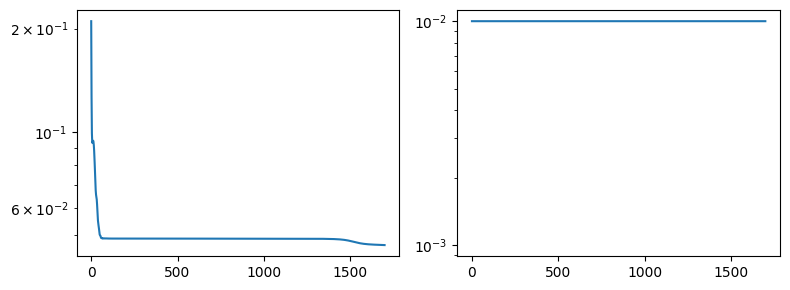

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


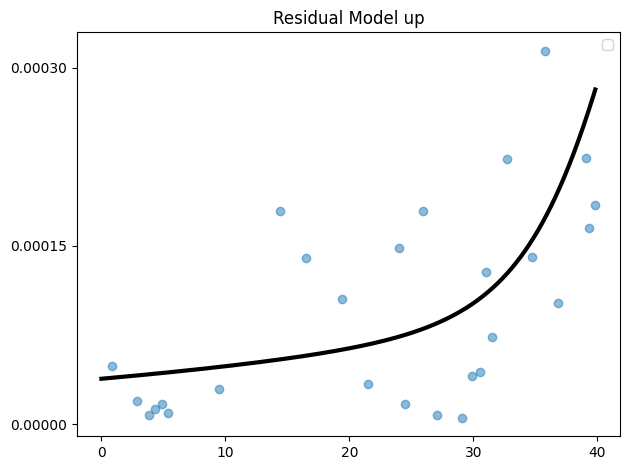

Epoch 1/1700


/Users/r/.venvs/p3inn/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_56. Received: the structure of inputs=['*']
  warnings.warn(


Epoch 2/1700
Epoch 3/1700
Epoch 4/1700
Epoch 5/1700
Epoch 6/1700
Epoch 7/1700
Epoch 8/1700
Epoch 9/1700
Epoch 10/1700
Epoch 11/1700
Epoch 12/1700
Epoch 13/1700
Epoch 14/1700
Epoch 15/1700
Epoch 16/1700
Epoch 17/1700
Epoch 18/1700
Epoch 19/1700
Epoch 20/1700
Epoch 21/1700
Epoch 22/1700
Epoch 23/1700
Epoch 24/1700
Epoch 25/1700
Epoch 26/1700
Epoch 27/1700
Epoch 28/1700
Epoch 29/1700
Epoch 30/1700
Epoch 31/1700
Epoch 32/1700
Epoch 33/1700
Epoch 34/1700
Epoch 35/1700
Epoch 36/1700
Epoch 37/1700
Epoch 38/1700
Epoch 39/1700
Epoch 40/1700
Epoch 41/1700
Epoch 42/1700
Epoch 43/1700
Epoch 44/1700
Epoch 45/1700
Epoch 46/1700
Epoch 47/1700
Epoch 48/1700
Epoch 49/1700
Epoch 50/1700
Epoch 51/1700
Epoch 52/1700
Epoch 53/1700
Epoch 54/1700
Epoch 55/1700
Epoch 56/1700
Epoch 57/1700
Epoch 58/1700
Epoch 59/1700
Epoch 60/1700
Epoch 61/1700
Epoch 62/1700
Epoch 63/1700
Epoch 64/1700
Epoch 65/1700
Epoch 66/1700
Epoch 67/1700
Epoch 68/1700
Epoch 69/1700
Epoch 70/1700
Epoch 71/1700
Epoch 72/1700
Epoch 73/1700


/Users/r/.venvs/p3inn/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_56. Received: the structure of inputs=['*']
  warnings.warn(


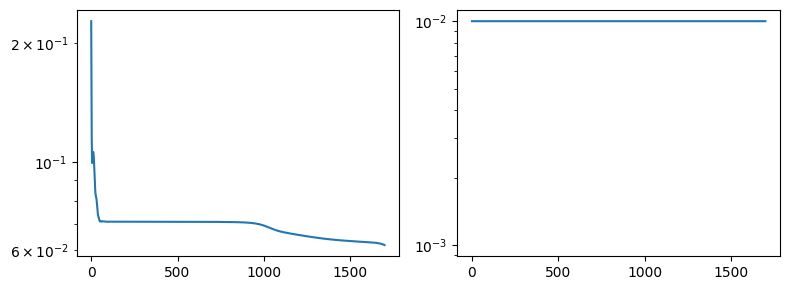

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


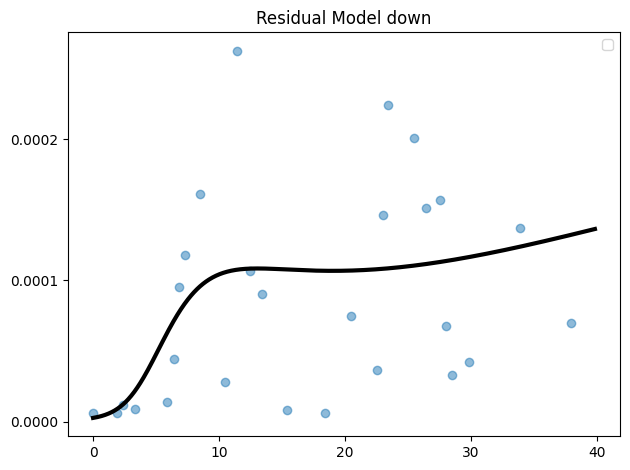

In [63]:
# Train residual models
residual_results = {}
for mask, sign, model_type in [(pos_mask, 1, "up"), (neg_mask, -1, "down")]:
    mask = np.squeeze(mask)
    x_data_res = x_data[mask, :]
    y_data_res = sign * median_residuals[mask, :]
    assert (y_data_res >= 0).all(), (y_data_res.min(), y_data_res.max())
    assert x_data_res.ndim == 2
    assert y_data_res.ndim == 2

    if len(std_models) == 0:
        model = make_model(
            x_data_res,
            y_data_res,
            layer_sizes=training_params_std.n_neurons_per_layer,
            activation=training_params_std.activation,
            # "sqrt_sqr" "abs" "relu" "softplus" "exp"
            positivity_method="softplus",
            l2_reg=experiment_params.l2_regularization,
        )
        # model.summary()
    else:
        model = std_models[model_type]

    res_result = train_model(
        model,
        x_data_res,
        y_data_res,
        x_eval,
        training_params_std,
        experiment_params,
        lr_schedule=keras.optimizers.schedules.PiecewiseConstantDecay(
            [10**8],
            [training_params_std.initial_learning_rate, 1e-7],
        ),
    )
    if len(res_result.loss_train) > 0:
        fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
        axs[0].semilogy(res_result.loss_train)
        axs[1].semilogy(res_result.learning_rates)
        plt.tight_layout()
        plt.savefig(p3inn_dir.image_dir / f"{model_type}_loss_and_lrs.png")
        if not experiment_params.visualize:
            plt.close()
        else:
            plt.show(block=BLOCK)

    assert (res_result.y_train_pred >= 0).all(), (
        res_result.y_train_pred.min(),
        res_result.y_train_pred.max(),
    )
    residual_results[model_type] = res_result

    residual_results[model_type].plot(f"Residual Model {model_type}")
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(3))
    plt.tight_layout()
    plt.legend()
    plt.savefig(p3inn_dir.image_dir / f"learned_residual_{model_type}.png")
    if not experiment_params.visualize:
        plt.close()
    else:
        plt.show(block=BLOCK)

In [155]:
y_train_pred_median = mean_result.y_train_pred + median_shift

In [184]:
def optimize_bound(
    *,
    mode: str,
    y_train: np.ndarray,
    pred_median: np.ndarray,
    pred_std: np.ndarray,
    quantile: float,
    c0: float = 0.0,
    c1: float = 1e6,
    maxiter: int = 1000,
    verbose=0,
):
    n_train = len(y_train)
    num_outliers = int(n_train * (1 - quantile) / 2)
    if verbose > 0:
        print(f"{num_outliers=}", n_train)

    def count_exceeding_upper_bound(c: float):
        bound = pred_median + c * pred_std
        f = np.count_nonzero(y_train >= bound) - num_outliers
        return f

    def count_exceeding_lower_bound(c: float):
        bound = pred_median - c * pred_std
        f = np.count_nonzero(y_train <= bound) - num_outliers
        return f

    objective_function = (
        count_exceeding_upper_bound if mode == "up" else count_exceeding_lower_bound
    )

    if verbose > 0:
        print(f"Initial bounds: [{c0}, {c1}]")
        print(f"Initial vals: [{objective_function(c0)}, {objective_function(c1)}]")
        print(f"Initial vals: [{objective_function(0.0)}, {objective_function(1e3)}]")

    try:
        optimal_c = optimize.bisect(objective_function, c0, c1, maxiter=maxiter)
        if verbose > 0:
            final_count = objective_function(optimal_c)
            print(f"Optimal c: {optimal_c}, Final count: {final_count}")
        assert optimal_c >= 0, optimal_c  # type: ignore
        return optimal_c
    except ValueError as e:
        if verbose > 0:
            print(f"Bisect method failed: {e}")
        raise e

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Quantile: 0.7
    c_up=1.19209
    c_down=1.35228

    PI contains 70.9%

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Quantile: 0.9
    c_up=2.38419
    c_down=2.38419

    PI contains 92.7%

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Quantile: 0.95
    c_up=2.86102
    c_down=2.44379

    PI contains 96.4%



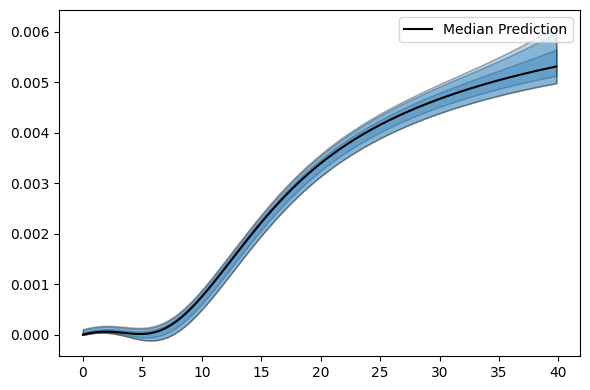

In [195]:
x_eval = mean_result.x_eval.squeeze()


fig, ax = plt.subplots(figsize=(6,4))
ax.plot(x_eval, y_eval_pred_median, "k-", label="Median Prediction")



quantile_cs: dict[float, tuple[float, float]] = {}
for quantile in sorted(experiment_params.quantiles):
    c_up, c_down = [
        optimize_bound(
            y_train=y_data,
            pred_median=y_train_pred_median,
            pred_std=residual_results[mode].model.predict(mean_result.x_train),
            mode=mode,
            quantile=quantile,
        )
        for mode in ["up", "down"]
    ]
    quantile_cs[quantile] = (float(c_up), float(c_down))  # type: ignore

    print(f"Quantile: {quantile}")
    print(f"    {c_up=:g}")
    print(f"    {c_down=:g}")
    print()

    upper_bound = (
        y_eval_pred_median + c_up * residual_results["up"].y_eval_pred
    ).squeeze()
    lower_bound = (
        y_eval_pred_median - c_down * residual_results["down"].y_eval_pred
    ).squeeze()

    p3inn_dir.get_pred_bound_file(quantile, "up").save(upper_bound)
    p3inn_dir.get_pred_bound_file(quantile, "down").save(lower_bound)

    n_inside = np.count_nonzero(
        (y_data < np.interp(x_data, x_eval, upper_bound))
        & (y_data > np.interp(x_data, x_eval, lower_bound))
    )
    print(f"    PI contains {n_inside / x_data.shape[0]:.1%}")
    print()

    for i, (q, bound_up, bound_down) in enumerate(p3inn_dir.iter_pred_PIs()):
        ax.fill_between(
            x=x_eval,
            y1=upper_bound,
            y2=lower_bound,
            color=f"C{0}",
            edgecolor="k",
            alpha=min(1, 0.35 / len(experiment_params.quantiles)),
        )

ax.legend()
plt.tight_layout()
plt.savefig(p3inn_dir.image_dir / "all_quantiles.png")
if not experiment_params.visualize:
    plt.close()
else:
    plt.show(block=BLOCK)

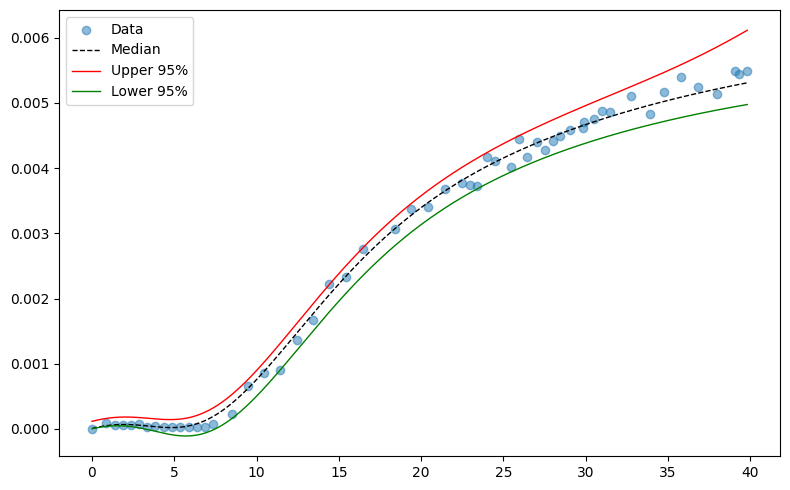

In [191]:

# Plot largest quantile result
plt.figure(figsize=(8, 5))
plt.scatter(x_data, y_data, alpha=0.5, label="Data")
plt.plot(mean_result.x_eval, y_eval_pred_median, "k--", lw=1, label="Median")
plt.plot(x_eval, upper_bound, "r-", lw=1, label=f"Upper {quantile:.0%}")
plt.plot(x_eval, lower_bound, "g-", lw=1, label=f"Lower {quantile:.0%}")
plt.legend()
plt.tight_layout()
plt.savefig(p3inn_dir.image_dir / "largest_quantile.png")
if not experiment_params.visualize:
    plt.close()
else:
    plt.show(block=BLOCK)